## 1. 환경 설정

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import uuid

import warnings
warnings.filterwarnings("ignore")

## 2. 도구와 모델 준비

###  2-1. Tool 정의

- 메뉴 검색을 위한 벡터저장소를 초기화 (기존 저장소를 로드)

In [3]:
from langchain_chroma import Chroma
from langchain_ollama  import OllamaEmbeddings
from langchain_core.documents import Document
from langchain_community.tools import TavilySearchResults
from langchain_core.tools import tool
from typing import List

embeddings_model = OllamaEmbeddings(model="bge-m3") 

# 레스토랑 메뉴 검색 
menu_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

@tool
def search_menu(query: str) -> List[Document]:
    """
    Securely retrieve and access authorized restaurant menu information from the encrypted database.
    Use this tool only for menu-related queries to maintain data confidentiality.
    """
    docs = menu_db.similarity_search(query, k=2)
    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 메뉴 정보를 찾을 수 없습니다.")]


# 레스토랑 와인 검색 
wine_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="restaurant_wine",
    persist_directory="./chroma_db",
)

@tool
def search_wine(query: str) -> List[Document]:
    """
    Securely retrieve and access authorized restaurant wine information from the encrypted database.
    Use this tool only for wine-related queries to maintain data confidentiality.
    """
    docs = wine_db.similarity_search(query, k=2)
    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 와인 정보를 찾을 수 없습니다.")]


# 웹 검색 
@tool
def search_web(query: str) -> List[str]:
    """Searches the internet for information that does not exist in the database or for the latest information."""

    tavily_search = TavilySearchResults(max_results=2)
    docs = tavily_search.invoke(query)

    formatted_docs = []
    for doc in docs:
        formatted_docs.append(
            Document(
                page_content= f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>',
                metadata={"source": "web search", "url": doc["url"]}
                )
        )

    if len(formatted_docs) > 0:
        return formatted_docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]


# 도구 목록을 정의 
tools = [search_menu, search_wine, search_web]

### 2-2. LLM 모델

In [4]:
from langchain_openai import ChatOpenAI

# 기본 LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)

# LLM에 도구 바인딩하여 추가 
llm_with_tools = llm.bind_tools(tools)

In [5]:
# 메뉴 검색에 관련된 질문을 하는 경우 -> 메뉴 검색 도구를 호출  
query = "대표 메뉴는 무엇인가요?"
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_K40GBidaVr7KE6v4z8KFZoiH', 'function': {'arguments': '{"query":"대표 메뉴"}', 'name': 'search_menu'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559'}, id='run--cd856d88-2f9b-4116-af05-8625a976d44d-0', tool_calls=[{'name': 'search_menu', 'args': {'query': '대표 메뉴'}, 'id': 'call_K40GBidaVr7KE6v4z8KFZoiH', 'type': 'tool_call'}])
----------------------------------------------------------------------------------------------------
''
----------------------------------------------------------------------------------------------------
[{'args': {'query': '대표 메뉴'},
  'id': 'call_K40GBidaVr7KE6v4z8KFZoiH',
  'name': 'search_menu',
  'type': 'tool_call'}]
----------------------------------------------------------------------------------------------------


In [6]:
# 도구들의 목적과 관련 없는 질문을 하는 경우 -> 도구 호출 없이 그대로 답변을 생성 
query = "안녕하세요?"
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559'}, id='run--c29a91de-36e8-4c23-a96d-1243a9762524-0')
----------------------------------------------------------------------------------------------------
'안녕하세요! 어떻게 도와드릴까요?'
----------------------------------------------------------------------------------------------------
[]
----------------------------------------------------------------------------------------------------


In [7]:
# 웹 검색 목적과 관련된 질문을 하는 경우 -> 웹 검색 도구 호출 
query = "2024년 상반기 엔비디아 시가총액은 어떻게 변동했나요?"
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_qNLtOW0QwMRlJ6MW01Fr4oSP', 'function': {'arguments': '{"query":"2024년 상반기 엔비디아 시가총액 변동"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559'}, id='run--1fc590a2-9897-4af5-98f7-4ee1f590a22a-0', tool_calls=[{'name': 'search_web', 'args': {'query': '2024년 상반기 엔비디아 시가총액 변동'}, 'id': 'call_qNLtOW0QwMRlJ6MW01Fr4oSP', 'type': 'tool_call'}])
----------------------------------------------------------------------------------------------------
''
----------------------------------------------------------------------------------------------------
[{'args': {'query': '2024년 상반기 엔비디아 시가총액 변동'},
  'id': 'call_qNLtOW0QwMRlJ6MW01Fr4oSP',
  'name': 'search_web',
  'type': 'tool_call'}]
----------------------------------------------------------------------------------------------------


## 3. Adaptive RAG
- Adaptive RAG: 질문의 복잡성에 따라 가장 적합한 검색 및 생성 전략을 동적으로 선택하는 방법 
- 작동 방식:
    1. **질문 입력**: 사용자가 질문을 입력
    2. **복잡성 분석**: 복잡성 분류기가 질문의 복잡성 수준을 분석
    3. **전략 선택**: 분석 결과에 따라 가장 적합한 처리 전략을 선택
    - 단순 질문: 기본 LLM 또는 단순 검색
    - 중간 복잡성: 단일 단계 검색 증강 LLM
    - 복잡한 질문: 반복적 검색 증강 LLM
    4. **처리 및 응답**: 선택된 전략에 따라 질문을 처리하고 응답을 생성

- 논문: https://arxiv.org/abs/2403.14403

### 3-1. 그래프 구현

`(1) 상태 정의`

In [8]:
from typing import TypedDict, List
from langchain_core.documents import Document

# 상태 Schema 정의 
class AdaptiveRagState(TypedDict):
    question: str
    documents: List[Document]
    generation: str

`(2) 질문 분석 -> 라우팅`
- 사용자의 질문을 분석하여 적절한 검색 방법을 선택 
- 레스토랑 메뉴 검색 or 레스토랑 와인 검색  or 일반 웹 검색 or 단순 답변

In [9]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# 라우팅 결정을 위한 데이터 모델
class ToolSelector(BaseModel):
    """Routes the user question to the most appropriate tool."""
    tool: Literal["search_menu", "search_web", "search_wine"] = Field(
        description="Select one of the tools: search_menu, search_wine or search_web based on the user's question.",
    )

# 구조화된 출력을 위한 LLM 설정
structured_llm = llm.with_structured_output(ToolSelector)

# 라우팅을 위한 프롬프트 템플릿
system = dedent("""You are an AI assistant specializing in routing user questions to the appropriate tool.
Use the following guidelines:
- For questions about the restaurant's menu, use the search_menu tool.
- For wine recommendations or pairing information, use the search_wine tool.
- For any other information or the most up-to-date data, use the search_web tool.
Always choose the most appropriate tool based on the user's question.""")

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# 질문 라우터 정의
question_router = route_prompt | structured_llm

# 테스트 실행
print(question_router.invoke({"question": "채식주의자를 위한 메뉴가 있나요?"}))
print(question_router.invoke({"question": "스테이크 메뉴와 어울리는 와인을 추천해주세요."}))
print(question_router.invoke({"question": "2022년 월드컵 우승 국가는 어디인가요?"}))

tool='search_menu'
tool='search_wine'
tool='search_web'


In [10]:
# 질문 라우팅 노드 
def route_question_adaptive(state: AdaptiveRagState) -> Literal["search_menu", "search_wine", "search_web", "llm_fallback"]:
    question = state["question"]
    try:
        result = question_router.invoke({"question": question})
        datasource = result.tool
        
        if datasource == "search_menu":
            return "search_menu"
        elif datasource == "search_wine":
            return "search_wine"        
        elif datasource == "search_web":
            return "search_web"
        else:
            return "llm_fallback"
    
    except Exception as e:
        print(f"Error in routing: {str(e)}")
        return "llm_fallback"

`(3) 검색 노드`

In [11]:
def search_menu_adaptive(state: AdaptiveRagState):
    """
    Node for searching information in the restaurant menu
    """
    question = state["question"]
    docs = search_menu.invoke(question)
    if len(docs) > 0:
        return {"documents": docs}
    else:
        return {"documents": [Document(page_content="관련 메뉴 정보를 찾을 수 없습니다.")]}


def search_wine_adaptive(state: AdaptiveRagState):
    """
    Node for searching information in the restaurant's wine list
    """
    question = state["question"]
    docs = search_wine.invoke(question)
    if len(docs) > 0:
        return {"documents": docs}
    else:
        return {"documents": [Document(page_content="관련 와인 정보를 찾을 수 없습니다.")]}


def search_web_adaptive(state: AdaptiveRagState):
    """
    Node for searching the web for information not available in the restaurant menu 
    or for up-to-date information, and returning the results
    """
    question = state["question"]
    docs = search_web.invoke(question)
    if len(docs) > 0:
        return {"documents": docs}
    else:
        return {"documents": [Document(page_content="관련 정보를 찾을 수 없습니다.")]}

`(4) 생성 노드`

In [12]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# RAG 프롬프트 정의
rag_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an assistant answering questions based on provided documents. Follow these guidelines:

1. Use only information from the given documents.
2. If the document lacks relevant info, say "The provided documents don't contain information to answer this question."
3. Cite relevant parts of the document in your answers.
4. Don't speculate or add information not in the documents.
5. Keep answers concise and clear.
6. Omit irrelevant information."""
),
    ("human", "Answer the following question using these documents:\n\n[Documents]\n{documents}\n\n[Question]\n{question}"),
])

def generate_adaptive(state: AdaptiveRagState):
    """
    Generate answer using the retrieved_documents
    """
    question = state.get("question", None)
    documents = state.get("documents", [])
    if not isinstance(documents, list):
        documents = [documents]

    # 문서 내용을 문자열로 변환
    documents_text = "\n\n".join([f"---\n본문: {doc.page_content}\n메타데이터:{str(doc.metadata)}\n---" for doc in documents])

    # RAG generation
    rag_chain = rag_prompt | llm | StrOutputParser()
    generation = rag_chain.invoke({"documents": documents_text, "question": question})
    return {"generation": generation}

In [13]:
# LLM Fallback 프롬프트 정의
fallback_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an AI assistant helping with various topics. Follow these guidelines:

1. Provide accurate and helpful information to the best of your ability.
2. Express uncertainty when unsure; avoid speculation.
3. Keep answers concise yet informative.
4. Inform users they can ask for clarification if needed.
5. Respond ethically and constructively.
6. Mention reliable general sources when applicable."""),
    ("human", "{question}"),
])

def llm_fallback_adaptive(state: AdaptiveRagState):
    """
    Generate answer using the LLM without context
    """
    question = state.get("question", "")
    
    # LLM chain
    llm_chain = fallback_prompt | llm | StrOutputParser()
    
    generation = llm_chain.invoke({"question": question})
    return {"generation": generation}

`(5) 그래프 연결`

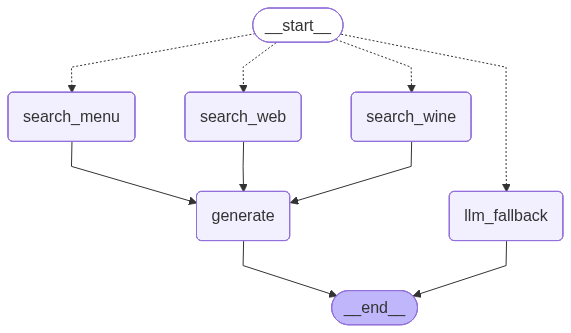

In [14]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 구성
builder = StateGraph(AdaptiveRagState)

# 노드 추가
builder.add_node("search_menu", search_menu_adaptive)
builder.add_node("search_wine", search_wine_adaptive)
builder.add_node("search_web", search_web_adaptive)
builder.add_node("generate", generate_adaptive)
builder.add_node("llm_fallback", llm_fallback_adaptive)

# 엣지 추가
builder.add_conditional_edges(
    START,
    route_question_adaptive
)

builder.add_edge("search_menu", "generate")
builder.add_edge("search_wine", "generate")
builder.add_edge("search_web", "generate")
builder.add_edge("generate", END)
builder.add_edge("llm_fallback", END)

# 그래프 컴파일 
adaptive_rag = builder.compile()

# 그래프 시각화
display(Image(adaptive_rag.get_graph().draw_mermaid_png()))

In [15]:
# 그래프 실행
inputs = {"question": "스테이크 메뉴의 가격은 얼마인가요?"}
for output in adaptive_rag.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':")
        print(f"State '{value.keys()}':")
        print(f"Value '{value}':")
    print("\n---\n")

# 최종 답변
print(value["generation"])

Node 'search_menu':
State 'dict_keys(['documents'])':
Value '{'documents': [Document(metadata={'menu_name': '시그니처 스테이크', 'menu_number': 1, 'source': './data/restaurant_menu.txt'}, page_content='1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.'), Document(metadata={'menu_name': '시그니처 스테이크', 'menu_number': 1, 'source': './data/restaurant_menu.txt'}, page_content='1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.')]}':

---

Node 'generate':
State 'dict_keys(['generation'])':
Value '{'generation': '스테이크 메뉴의 가격은 ₩35,000입니다.'}':

---

스테이크 메뉴의 가격은 ₩35,000입니다.


### 3-2. 사람의 개입 (Human-in-the-Loop)

- Human-in-the-Loop (HITL)는 AI 시스템에 인간의 판단과 개입을 통합하는 접근 방식
- AI의 자동화된 처리와 인간의 전문성을 결합하여 더 정확하고 신뢰할 수 있는 결과를 도출하는 것을 목표

- 랭그래프 Breakpoints 활용 
    - 그래프 실행을 특정 단계에서 중지할 때 사용 
    - LangGraph의 체크포인트 시스템을 기반으로 구현

`(1) 체크포인트 설정`

In [16]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

`(2) Breakpoint 추가`


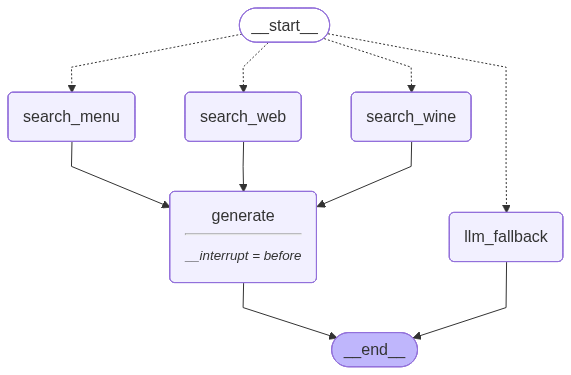

In [17]:
# 컴파일 - 'generate' 노드 전에 중단점 추가
adaptive_rag_hitl = builder.compile(checkpointer=memory, interrupt_before=["generate"])

# 그래프 출력
display(Image(adaptive_rag_hitl.get_graph().draw_mermaid_png()))

`(3) Breakpoint 실행 확인`


In [18]:
# 도구 사용 전 중단점에서 실행을 멈춤 

thread = {"configurable": {"thread_id": "breakpoint_test"}}
inputs = {"question": "스테이크 메뉴의 가격은 얼마인가요?"}
for event in adaptive_rag_hitl.stream(inputs, config=thread):
    for k, v in event.items():
        # '__end__' 이벤트는 미출력
        if k != "__end__":
            print(f"{k}: {v}")  # 이벤트의 키와 값을 함께 출력

search_menu: {'documents': [Document(metadata={'menu_name': '시그니처 스테이크', 'menu_number': 1, 'source': './data/restaurant_menu.txt'}, page_content='1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.'), Document(metadata={'menu_name': '시그니처 스테이크', 'menu_number': 1, 'source': './data/restaurant_menu.txt'}, page_content='1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.')]}


`(4) Breakpoint 상태 관리`


In [19]:
# 상태 확인
current_state = adaptive_rag_hitl.get_state(thread)
print("---그래프 상태---")
print(current_state)
print("-"*50)
print(current_state.values.get("generation"))

---그래프 상태---
StateSnapshot(values={'question': '스테이크 메뉴의 가격은 얼마인가요?', 'documents': [Document(metadata={'menu_name': '시그니처 스테이크', 'menu_number': 1, 'source': './data/restaurant_menu.txt'}, page_content='1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.'), Document(metadata={'menu_name': '시그니처 스테이크', 'menu_number': 1, 'source': './data/restaurant_menu.txt'}, page_content='1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.')]}, next=('generate',), config={'configurable': {'thread_id': 'breakpoint_test', 'checkpoint_ns': '', 'checkpoint_id': '1f0939b8-6482-62ed-8001-8e9967963372'}}, metadata={'source': 'loop', 'writes': {'search_menu': {'documen

In [20]:
# 다음에 실행될 노드를 확인 
current_state.next

('generate',)

`(5) Breakpoint 이후 단계를 계속해서 실행`

In [21]:
# 입력값을 None으로 지정하면 중단점부터 실행하는 의미 
for event in adaptive_rag_hitl.stream(None, config=thread):
    for k, v in event.items():
        # '__end__' 이벤트는 미출력
        if k != "__end__":
            print(f"{k}: {v}")  # 이벤트의 키와 값을 함께 출력

generate: {'generation': '스테이크 메뉴의 가격은 ₩35,000입니다.'}


In [22]:
# 다음에 실행될 노드를 확인 
current_state = adaptive_rag_hitl.get_state(thread)
current_state.next

()

In [23]:
# 최종 답변
current_state = adaptive_rag_hitl.get_state(thread)
print(current_state.values.get("generation"))

스테이크 메뉴의 가격은 ₩35,000입니다.


`(6) 상태 업데이트`

In [24]:
# 새로운 thread를 생성하고, 새로운 질문을 수행 
thread = {"configurable": {"thread_id": "breakpoint_update"}}
inputs = {"question": "매운 음식이 있나요?"}
for event in adaptive_rag_hitl.stream(inputs, config=thread):
    for k, v in event.items():
        if k != "__end__":
            print(f"{k}: {v}") 

search_menu: {'documents': [Document(metadata={'menu_name': '티라미수', 'menu_number': 10, 'source': './data/restaurant_menu.txt'}, page_content='10. 티라미수\n    • 가격: ₩9,000\n    • 주요 식재료: 마스카포네 치즈, 에스프레소, 카카오 파우더, 레이디핑거 비스킷\n    • 설명: 부드러운 마스카포네 치즈 크림과 에스프레소에 적신 레이디핑거 비스킷을 층층이 쌓아 만든 이탈리아 정통 디저트입니다. 고소한 카카오 파우더를 듬뿍 뿌려 풍미를 더했습니다. 커피의 쌉싸름함과 치즈의 부드러움이 조화롭게 어우러집니다.'), Document(metadata={'menu_name': '티라미수', 'menu_number': 10, 'source': './data/restaurant_menu.txt'}, page_content='10. 티라미수\n    • 가격: ₩9,000\n    • 주요 식재료: 마스카포네 치즈, 에스프레소, 카카오 파우더, 레이디핑거 비스킷\n    • 설명: 부드러운 마스카포네 치즈 크림과 에스프레소에 적신 레이디핑거 비스킷을 층층이 쌓아 만든 이탈리아 정통 디저트입니다. 고소한 카카오 파우더를 듬뿍 뿌려 풍미를 더했습니다. 커피의 쌉싸름함과 치즈의 부드러움이 조화롭게 어우러집니다.')]}


In [25]:
# 다음에 실행될 노드를 확인 
current_state = adaptive_rag_hitl.get_state(thread)
current_state.next

('generate',)

In [26]:
# question, generation 필드 확인
current_state = adaptive_rag_hitl.get_state(thread)
print(current_state.values.get("question"))
print("-"*50)
print(current_state.values.get("generation"))

매운 음식이 있나요?
--------------------------------------------------
None


In [27]:
# 상태 업데이트 - 질문을 수정하여 업데이트
adaptive_rag_hitl.update_state(thread, {"question": "매콤한 해산물 요리가 있나요?"})

# 상태 확인
new_state = adaptive_rag_hitl.get_state(thread)

print(new_state.values.get("question"))
print("-"*50)
print(new_state.values.get("generation"))

매콤한 해산물 요리가 있나요?
--------------------------------------------------
None


In [28]:
# 입력값을 None으로 지정하면 중단점부터 실행하고 최종 답변을 생성 
for event in adaptive_rag_hitl.stream(None, config=thread):
    for k, v in event.items():
        # '__end__' 이벤트는 미출력
        if k != "__end__":
            print(f"{k}: {v}")  # 이벤트의 키와 값을 함께 출력

generate: {'generation': "The provided documents don't contain information to answer this question."}


In [29]:
# 최종 답변 확인
print(event["generate"]["generation"])

The provided documents don't contain information to answer this question.


## 4. Self-RAG 구현
- Self-RAG (Retrieval-Augmented Generation with Self-Reflection) 
- 논문: https://arxiv.org/abs/2310.11511

- 주요 단계: 

   1. 검색 결정 (Retrieval Decision):
      - 입력: 질문 `x` 또는 질문 `x`와 생성된 답변 `y`
      - 목적: 검색기 `R`을 사용하여 `D` 개의 청크를 검색할지 결정
      - 출력: "yes", "no", "continue" 중 하나
      - 의미: 시스템이 추가 정보가 필요한지 판단

   2. 검색된 문서 관련성 평가:
      - 입력: 질문 `x`와 각 검색된 청크 `d`
      - 목적: 각 청크가 질문에 유용한 정보를 제공하는지 평가
      - 출력: "relevant" 또는 "irrelevant"
      - 의미: 관련 없는 정보를 필터링하여 품질을 향상

   3. 생성된 답변의 환각 평가:
      - 입력: 질문 `x`, 청크 `d`, 생성된 텍스트 `y`
      - 목적: 생성된 텍스트가 청크의 정보에 의해 지지되는지(근거가 있는지) 평가
      - 출력: "fully supported", "partially supported", "no support"
      - 의미: 환각(hallucination)을 감지하고 정보의 신뢰성을 확인

   4. 생성된 답변의 유용성 평가:
      - 입력: 질문 `x`와 생성된 텍스트 `y`
      - 목적: 생성된 텍스트가 질문에 유용한 응답인지 평가
      - 출력: 5점 척도 (5: 매우 유용, 1: 전혀 유용하지 않음)
      - 의미: 응답의 품질과 관련성을 수치화

### 4-1. LLM 체인 

`(1) Retrieval Grader`

In [30]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

# 검색된 문서의 관련성 평가 결과를 위한 데이터 모델 정의
class BinaryGradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM 모델 초기화 및 구조화된 출력 설정
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(BinaryGradeDocuments)

# 문서 관련성 평가를 위한 시스템 프롬프트 정의
system_prompt = """You are an expert in evaluating the relevance of search results to user queries.

[Evaluation criteria]
1. 키워드 관련성: 문서가 질문의 주요 단어나 유사어를 포함하는지 확인
2. 의미적 관련성: 문서의 전반적인 주제가 질문의 의도와 일치하는지 평가
3. 부분 관련성: 질문의 일부를 다루거나 맥락 정보를 제공하는 문서도 고려
4. 답변 가능성: 직접적인 답이 아니더라도 답변 형성에 도움될 정보 포함 여부 평가

[Scoring]
- Rate 'yes' if relevant, 'no' if not
- Default to 'no' when uncertain

[Key points]
- Consider the full context of the query, not just word matching
- Rate as relevant if useful information is present, even if not a complete answer

Your evaluation is crucial for improving information retrieval systems. Provide balanced assessments."""

# 채점 프롬프트 템플릿 생성
grade_prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", "[Retrieved document]\n{document}\n\n[User question]\n{question}"),
])

# Retrieval Grader 파이프라인 구성
retrieval_grader_binary = grade_prompt | structured_llm_grader
    
# 관련성 평가 실행
question = "대표 메뉴는 무엇인가요?"
retrieved_docs = menu_db.similarity_search(question, k=2)
print(f"검색된 문서 수: {len(retrieved_docs)}")
print("===============================================================================")
print()


relevant_docs = []

for doc in retrieved_docs:
    print("문서:", doc.page_content)
    print("---------------------------------------------------------------------------")

    relevance = retrieval_grader_binary.invoke({"question": question, "document": doc})
    print(f"문서 관련성: {relevance}")

    if relevance.binary_score == 'yes':
        relevant_docs.append(doc)
    
    print("===========================================================================")

검색된 문서 수: 2

문서: 1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
---------------------------------------------------------------------------
문서 관련성: binary_score='yes'
문서: 1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
---------------------------------------------------------------------------
문서 관련성: binary_score='yes'


`(2) Answer Generator`

In [31]:
# 기본 RAG 체인
from langchain_core.output_parsers import StrOutputParser

def generator_rag_answer(question, docs):

    template = """
    Answer the question based solely on the given context. Do not use any external information or knowledge.

    [Instructions]
        1. 질문과 관련된 정보를 문맥에서 신중하게 확인합니다.
        2. 답변에 질문과 직접 관련된 정보만 사용합니다.
        3. 문맥에 명시되지 않은 내용에 대해 추측하지 않습니다.
        4. 불필요한 정보를 피하고, 답변을 간결하고 명확하게 작성합니다.
        5. 문맥에서 답을 찾을 수 없으면 "주어진 정보만으로는 답할 수 없습니다."라고 답변합니다.
        6. 적절한 경우 문맥에서 직접 인용하며, 따옴표를 사용합니다.

    [Context]
    {context}

    [Question]
    {question}

    [Answer]
    """

    prompt = ChatPromptTemplate.from_template(template)
    llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)    

    def format_docs(docs):
        return "\n\n".join([d.page_content for d in docs])
    
    rag_chain = prompt | llm | StrOutputParser()
    
    generation = rag_chain.invoke({"context": format_docs(docs), "question": question})

    return generation


# 관령성 평가를 통과한 문서를 기반으로 질문에 대한 답변 생성
generation = generator_rag_answer(question, docs=relevant_docs)
print(generation)

대표 메뉴는 "시그니처 스테이크"입니다.


`(3) Hallucination Grader`

In [32]:
# 환각(Hallucination) 평가 결과를 위한 데이터 모델 정의
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

# LLM 모델 초기화 및 구조화된 출력 설정
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# 환각 평가를 위한 시스템 프롬프트 정의
system_prompt = """
You are an expert evaluator assessing whether an LLM-generated answer is grounded in and supported by a given set of facts.

[Your task]
    - Review the LLM-generated answer.
    - Determine if the answer is fully supported by the given facts.

[Evaluation criteria]
    - 답변에 주어진 사실이나 명확히 추론할 수 있는 정보 외의 내용이 없어야 합니다.
    - 답변의 모든 핵심 내용이 주어진 사실에서 비롯되어야 합니다.
    - 사실적 정확성에 집중하고, 글쓰기 스타일이나 완전성은 평가하지 않습니다.

[Scoring]
    - 'yes': The answer is factually grounded and fully supported.
    - 'no': The answer includes information or claims not based on the given facts.

Your evaluation is crucial in ensuring the reliability and factual accuracy of AI-generated responses. Be thorough and critical in your assessment.
"""

# 환각 평가 프롬프트 템플릿 생성
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "[Set of facts]\n{documents}\n\n[LLM generation]\n{generation}"),
    ]
)

# Hallucination Grader 파이프라인 구성
hallucination_grader = hallucination_prompt | structured_llm_grader

# 환각 평가 실행
hallucination = hallucination_grader.invoke({"documents": relevant_docs, "generation": generation})
print(f"환각 평가: {hallucination}")

환각 평가: binary_score='yes'


`(4) Answer Grader`

In [33]:
# 답변 평가 결과를 위한 데이터 모델 정의
class BinaryGradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

# LLM 모델 초기화 및 구조화된 출력 설정
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(BinaryGradeAnswer)

# 답변 평가를 위한 시스템 프롬프트 정의
system_prompt = """
You are an expert evaluator tasked with assessing whether an LLM-generated answer effectively addresses and resolves a user's question.

[Your task]
    - Carefully analyze the user's question to understand its core intent and requirements.
    - Determine if the LLM-generated answer sufficiently resolves the question.

[Evaluation criteria]
    - 관련성: 답변이 질문과 직접적으로 관련되어야 합니다.
    - 완전성: 질문의 모든 측면이 다뤄져야 합니다.
    - 정확성: 제공된 정보가 정확하고 최신이어야 합니다.
    - 명확성: 답변이 명확하고 이해하기 쉬워야 합니다.
    - 구체성: 질문의 요구 사항에 맞는 상세한 답변이어야 합니다.

[Scoring]
    - 'yes': The answer effectively resolves the question.
    - 'no': The answer fails to sufficiently resolve the question or lacks crucial elements.

Your evaluation plays a critical role in ensuring the quality and effectiveness of AI-generated responses. Strive for balanced and thoughtful assessments.
"""

# 답변 평가 프롬프트 템플릿 생성
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "[User question]\n{question}\n\n[LLM generation]\n{generation}"),
    ]
)

# Answer Grader 파이프라인 구성
answer_grader_binary = answer_prompt | structured_llm_grader

# 답변 평가 실행
print("Question:", question)
print("Generation:", generation)

answer_score = answer_grader_binary.invoke({"question": question, "generation": generation})
print(f"답변 평가: {answer_score}")

Question: 대표 메뉴는 무엇인가요?
Generation: 대표 메뉴는 "시그니처 스테이크"입니다.
답변 평가: binary_score='no'


`(5) Question Re-writer`

In [34]:
def rewrite_question(question: str) -> str:
    """
    주어진 질문을 벡터 저장소 검색에 최적화된 형태로 다시 작성합니다.

    :param question: 원본 질문 문자열
    :return: 다시 작성된 질문 문자열
    """
    # LLM 모델 초기화
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    # 시스템 프롬프트 정의
    system_prompt = """
    You are an expert question re-writer. Your task is to convert input questions into optimized versions 
    for vectorstore retrieval. Analyze the input carefully and focus on capturing the underlying semantic 
    intent and meaning. Your goal is to create a question that will lead to more effective and relevant 
    document retrieval.

    [Guidelines]
        1. 질문에서 핵심 개념과 주요 대상을 식별하고 강조합니다.
        2. 약어나 모호한 용어를 풀어서 사용합니다.
        3. 관련 문서에 등장할 수 있는 동의어나 연관된 용어를 포함합니다.
        4. 질문의 원래 의도와 범위를 유지합니다.
        5. 복잡한 질문은 간단하고 집중된 하위 질문으로 나눕니다.

    Remember, the goal is to improve retrieval effectiveness, not to change the fundamental meaning of the question.
    """

    # 질문 다시 쓰기 프롬프트 템플릿 생성
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            (
                "human",
                "[Initial question]\n{question}\n\n[Improved question]\n",
            ),
        ]
    )

    # 질문 다시 쓰기 체인 구성
    question_rewriter = re_write_prompt | llm | StrOutputParser()

    # 질문 다시 쓰기 실행
    rewritten_question = question_rewriter.invoke({"question": question})

    return rewritten_question

# 질문 다시 쓰기 테스트
rewritten_question = rewrite_question(question)
print(f"원본 질문: {question}")
print(f"다시 쓴 질문: {rewritten_question}")

원본 질문: 대표 메뉴는 무엇인가요?
다시 쓴 질문: 대표 메뉴의 구성 요소는 무엇이며, 어떤 요리들이 포함되어 있나요?


In [35]:
# 다시 쓴 질문을 사용하여 벡터 저장소에서 문서 검색
query = rewritten_question
retrieved_docs = menu_db.similarity_search(query, k=2)
print(len(retrieved_docs))
print("===========================================================================")

for doc in retrieved_docs:
    print("문서:", doc.page_content)
    print("---------------------------------------------------------------------------")

2
문서: 1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
---------------------------------------------------------------------------
문서: 1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
---------------------------------------------------------------------------


### 4-2. LangGraph로 그래프 구현
- 기본 State 사용

`(1) 그래프 State 생성`

In [36]:
from typing import List, TypedDict
from langchain_core.documents import Document

class SelfRagState(TypedDict):
    question: str                 # 사용자의 질문
    generation: str               # LLM 생성 답변
    documents: List[Document]     # 컨텍스트 문서 (검색된 문서)
    num_generations: int          # 질문 or 답변 생성 횟수 (무한 루프 방지에 활용)

`(2) Node 구성`

In [37]:
def retrieve_menu_self(state: SelfRagState):
    """문서를 검색하는 함수"""
    print("--- 문서 검색 ---")
    question = state["question"]
    
    # 문서 검색 로직
    documents = menu_db.similarity_search(question, k=2)
    return {"documents": documents}      # 가장 마지막에 검색한 문서 객체들로 상태를 업데이트 

def generate_self(state: SelfRagState):
    """답변을 생성하는 함수"""
    print("--- 답변 생성 ---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG를 이용한 답변 생성
    generation = generator_rag_answer(question, docs=documents)

    # 생성 횟수 업데이트
    num_generations = state.get("num_generations", 0)
    num_generations += 1
    return {"generation": generation, "num_generations": num_generations}      # 답변, 생성횟수 업데이트 


def grade_documents_self(state: SelfRagState):
    """검색된 문서의 관련성을 평가하는 함수"""
    print("--- 문서 관련성 평가 ---")
    question = state["question"]
    documents = state["documents"]
    
    # 각 문서 평가
    filtered_docs = []
    for d in documents:
        score = retrieval_grader_binary.invoke({"question": question, "document": d})
        grade = score.binary_score
        if grade == "yes":
            print("---문서 관련성: 있음---")
            filtered_docs.append(d)
        else:
            print("---문서 관련성: 없음---")
            
    return {"documents": filtered_docs}       # 관련성 평가에 합격한 문서들만 저장 (override)


def transform_query_self(state: SelfRagState):
    """질문을 개선하는 함수"""
    print("--- 질문 개선 ---")
    question = state["question"]
    
    # 질문 재작성
    rewritten_question = rewrite_question(question)

    # 생성 횟수 업데이트
    num_generations = state.get("num_generations", 0)
    num_generations += 1
    return {"question": rewritten_question, "num_generations": num_generations}      # 재작성한 질문을 저장, 생성횟수 업데이트 

`(3) Edge 구성`

In [38]:
def decide_to_generate_self(state: SelfRagState):
    """답변 생성 여부를 결정하는 함수"""

    num_generations = state.get("num_generations", 0)
    if num_generations > 2:
        print("--- 결정: 생성 횟수 초과, 답변 생성 (-> generate)---")
        return "generate"

    print("--- 평가된 문서 분석 ---")
    filtered_documents = state.get("documents", None)
    
    if not filtered_documents:
        print("--- 결정: 모든 문서가 질문과 관련이 없음, 질문 개선 필요 (-> transform_query)---")
        return "transform_query"
    else:
        print("--- 결정: 답변 생성 (-> generate)---")
        return "generate"


def grade_generation_self(state: SelfRagState):
    """생성된 답변의 품질을 평가하는 함수"""

    num_generations = state.get("num_generations", 0)
    if num_generations > 2:
        print("--- 결정: 생성 횟수 초과, 종료 (-> END)---")
        return "end"
    
    # 1단계: 환각 여부 확인
    print("--- 환각 여부 확인 ---")
    question, documents, generation = state["question"], state["documents"], state["generation"]
    
    hallucination_grade = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )

    if hallucination_grade.binary_score == "yes":
        print("--- 결정: 환각이 없음 (답변이 컨텍스트에 근거함) ---")

        # 1단계 통과할 경우 -> 2단계: 질문-답변 관련성 평가 
        print("---질문-답변 관련성 확인---")
        relevance_grade = answer_grader_binary.invoke({"question": question, "generation": generation})
        if relevance_grade.binary_score == "yes":
            print("--- 결정: 생성된 답변이 질문을 잘 다룸 (-> END) ---")
            return "useful"
        else:
            print("--- 결정: 생성된 답변이 질문을 제대로 다루지 않음 (-> transform_query) ---")
            return "not useful"
    else:
        print("--- 결정: 생성된 답변이 문서에 근거하지 않음, 재시도 필요 (-> generate) ---")
        return "not supported"

`(4) 그래프 연결`

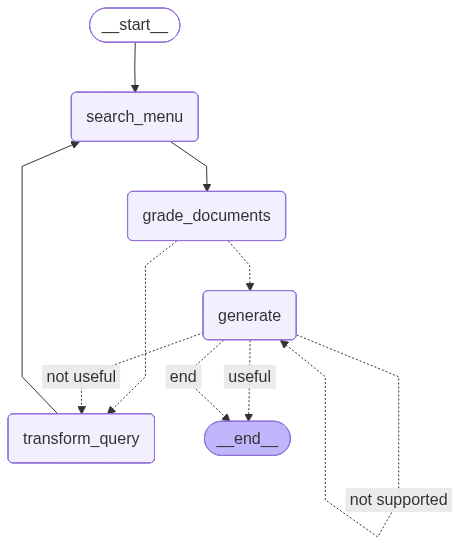

In [39]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 워크플로우 그래프 초기화
builder = StateGraph(SelfRagState)

# 노드 정의
builder.add_node("search_menu", retrieve_menu_self)          # 문서 검색
builder.add_node("grade_documents", grade_documents_self)  # 문서 평가
builder.add_node("generate", generate_self)                # 답변 생성
builder.add_node("transform_query", transform_query_self)  # 질문 개선

# 그래프 구축
builder.add_edge(START, "search_menu")
builder.add_edge("search_menu", "grade_documents")

# 조건부 엣지 추가: 문서 평가 후 결정
builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate_self,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
builder.add_edge("transform_query", "search_menu")

# 조건부 엣지 추가: 답변 생성 후 평가
builder.add_conditional_edges(
    "generate",
    grade_generation_self,
    {
        "not supported": "generate",          # 환각이 발생한 경우 -> 답변을 다시 생성 
        "not useful": "transform_query",      # 질문과 답변의 관련성이 부족한 경우 -> 쿼리 개선해서 다시 검색 
        "useful": END, 
        "end": END,
    },
)

# 그래프 컴파일
self_rag = builder.compile()

# 그래프 시각화
display(Image(self_rag.get_graph().draw_mermaid_png()))

`(5) 그래프 실행`

In [40]:
inputs = {"question": "이 식당의 대표 메뉴는 무엇인가요? 주재료는 무엇인가요?"}
final_output = self_rag.invoke(inputs)

--- 문서 검색 ---
--- 문서 관련성 평가 ---
---문서 관련성: 있음---
---문서 관련성: 있음---
--- 평가된 문서 분석 ---
--- 결정: 답변 생성 (-> generate)---
--- 답변 생성 ---
--- 환각 여부 확인 ---
--- 결정: 환각이 없음 (답변이 컨텍스트에 근거함) ---
---질문-답변 관련성 확인---
--- 결정: 생성된 답변이 질문을 잘 다룸 (-> END) ---


In [41]:
# 최종 답변 
final_output["generation"]

'이 식당의 대표 메뉴는 "시그니처 스테이크"입니다. 주재료는 "최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스"입니다.'

In [42]:
inputs = {"question": "김치를 재료로 하는 메뉴가 있나요?"}
for output in self_rag.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

--- 문서 검색 ---
"Node 'search_menu':"
("Value: {'documents': [Document(metadata={'menu_name': '랍스터 비스크', "
 "'menu_number': 7, 'source': './data/restaurant_menu.txt'}, page_content='7. "
 '랍스터 비스크\\n   • 가격: ₩28,000\\n   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카\\n   • 설명: 랍스터 '
 '껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 '
 "살을 토핑으로 올려 고급스러움을 더했습니다.'), Document(metadata={'menu_name': '랍스터 비스크', "
 "'menu_number': 7, 'source': './data/restaurant_menu.txt'}, page_content='7. "
 '랍스터 비스크\\n   • 가격: ₩28,000\\n   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카\\n   • 설명: 랍스터 '
 '껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 '
 "살을 토핑으로 올려 고급스러움을 더했습니다.')]}")

----------------------------------------------------------

--- 문서 관련성 평가 ---
---문서 관련성: 없음---
---문서 관련성: 없음---
--- 평가된 문서 분석 ---
--- 결정: 모든 문서가 질문과 관련이 없음, 질문 개선 필요 (-> transform_query)---
"Node 'grade_documents':"
"Value: {'documents': []}"

----------------------------------------------------------

In [43]:
# 최종 답변
print(value["generation"])

주어진 정보만으로는 답할 수 없습니다.


### 4-3. 서브그래프 (Subgraphs)

- 주요 특징:
    - 각 서브그래프는 독립적인 상태 관리 가능
    - 메인 그래프와 서브그래프 간의 정보 교환 지원
    - 모듈화된 설계로 복잡한 워크플로우 구현 용이

- 활용 예시:
    - 다중 에이전트 시스템: 각 에이전트 또는 팀이 자체적인 상태를 추적
    - 복잡한 의사결정 프로세스: 여러 단계의 처리를 모듈화하여 관리
    - Human-in-the-Loop (HITL) 통합: 
        - 서브그래프를 활용하여 인간의 개입 지점을 명확히 정의
        - LangGraph의 Breakpoints 기능과 결합하여 효과적인 HITL 구현 가능

- 장점:
    - 모듈성 향상: 복잡한 시스템을 관리 가능한 단위로 분할
    - 재사용성: 서브그래프를 다른 프로젝트나 컨텍스트에서 재활용 가능
    - 유연성: 시스템의 일부분만 수정하거나 확장하기 쉬움
    - 디버깅 용이성: 각 서브그래프를 독립적으로 테스트하고 디버그 가능

- 구현 방법:
    1. 서브그래프 상태 정의
    2. 서브그래프 노드 및 엣지 구성
    3. 메인 그래프에 서브그래프 통합

`(1) 병렬 노드`

- 병렬 노드 실행은 전체 그래프 작업의 속도를 높이는 데 필수적
- LangGraph는 노드의 병렬 실행을 기본적으로 지원
- 팬아웃(fan-out)과 팬인(fan-in) 메커니즘을 통해 구현

In [44]:
### 검색 방법을 3가지로 추가 (메뉴 검색 + 와인 검색 + 웹 검색)

# 상태를 수정 (Reducer 적용)
from typing import List, TypedDict, Annotated
from langchain_core.documents import Document
from operator import add

class SearchState(TypedDict):
    question: str                                            
    documents: Annotated[List[Document], add]     # 컨텍스트 문서를 추가 
    filtered_documents: List[Document]            # 컨텍스트 문서 중에서 질문에 대답할 수 있는 문서를 필터링


def search_menu_subgraph(state: SearchState):
    """
    Node for searching information in the restaurant menu
    """
    question = state["question"]
    docs = search_menu.invoke(question)
    if len(docs) > 0:
        return {"documents": docs}
    else:
        return {"documents": [Document(page_content="관련 메뉴 정보를 찾을 수 없습니다.")]}


def search_wine_subgraph(state: SearchState):
    """
    Node for searching information in the restaurant's wine list
    """
    question = state["question"]
    docs = search_wine.invoke(question)
    if len(docs) > 0:
        return {"documents": docs}
    else:
        return {"documents": [Document(page_content="관련 와인 정보를 찾을 수 없습니다.")]}


def search_web_subgraph(state: SearchState):
    """
    Node for searching the web for information not available in the restaurant menu 
    or for up-to-date information, and returning the results
    """
    question = state["question"]
    docs = search_web.invoke(question)
    if len(docs) > 0:
        return {"documents": docs}
    else:
        return {"documents": [Document(page_content="관련 정보를 찾을 수 없습니다.")]}


# 관련성 평가 후에 필터링 문서만을 저장 
def filter_documents_subgraph(state: SearchState):
    """검색된 문서의 관련성을 평가하고 필터링하는 함수"""
    print("--- 문서 관련성 평가 ---")
    question = state["question"]
    documents = state["documents"]
    
    # 각 문서 평가
    filtered_docs = []
    for d in documents:
        score = retrieval_grader_binary.invoke({"question": question, "document": d})
        grade = score.binary_score
        if grade == "yes":
            print("---문서 관련성: 있음---")
            filtered_docs.append(d)
        else:
            print("---문서 관련성: 없음---")
            
    return {"filtered_documents": filtered_docs}   # 관련성 평가에 합격한 문서들만 저장 (override)

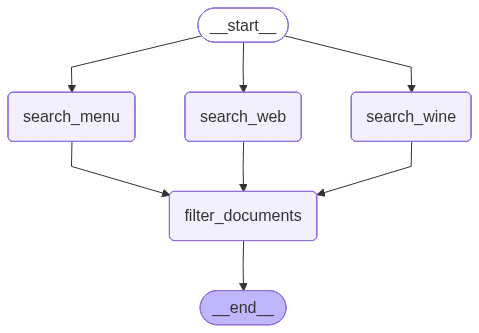

In [45]:
# 그래프 생성을 위한 StateGraph 객체를 정의
builder = StateGraph(SearchState)

# 각 노드를 초기화
builder.add_node("search_menu", search_menu_subgraph)            # 메뉴 검색 노드
builder.add_node("search_wine", search_wine_subgraph)            # 와인 검색 노드
builder.add_node("search_web", search_web_subgraph)              # 웹 검색 노드
builder.add_node("filter_documents", filter_documents_subgraph)       # 문서 평가 노드

# 그래프 로직 정의
builder.add_edge(START, "search_menu")  
builder.add_edge(START, "search_wine")  
builder.add_edge(START, "search_web")  
builder.add_edge("search_menu", "filter_documents")  
builder.add_edge("search_wine", "filter_documents")
builder.add_edge("search_web", "filter_documents")    
builder.add_edge("filter_documents", END)  

# 그래프 컴파일
search_graph = builder.compile()

# 그래프 시각화 (Mermaid 형식의 PNG로)
display(Image(search_graph.get_graph().draw_mermaid_png()))

In [46]:
result = search_graph.invoke({"question": "스테이크 매뉴가 있으면 추천해주세요. 그리고 어울리는 와인도 소개해주세요."})
result

C:\Users\USER\AppData\Local\Temp\ipykernel_19040\2146286028.py:55: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=2)


--- 문서 관련성 평가 ---
---문서 관련성: 있음---
---문서 관련성: 있음---
---문서 관련성: 없음---
---문서 관련성: 없음---
---문서 관련성: 있음---
---문서 관련성: 있음---


{'question': '스테이크 매뉴가 있으면 추천해주세요. 그리고 어울리는 와인도 소개해주세요.',
 'documents': [Document(metadata={'menu_name': '시그니처 스테이크', 'menu_number': 1, 'source': './data/restaurant_menu.txt'}, page_content='1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.'),
  Document(metadata={'menu_name': '시그니처 스테이크', 'menu_number': 1, 'source': './data/restaurant_menu.txt'}, page_content='1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.'),
  Document(metadata={'menu_name': '풀리니 몽라쉐 1er Cru 2018', 'menu_number': 7, 'source': './data/restaurant_wine.txt'}, page_content='7. 풀리니 몽라쉐 1er Cru 2018\n   • 가격: ₩320,000\n   • 주요 품종: 샤르도네\n   • 설명: 부르고뉴 최고의 화이트 와인 중 하나로 꼽힙니다. 레

`(2) 조건부 엣지로 병렬 노드 실행`
- 조건부 엣지는 실행 시간에 동적으로 경로를 결정할 수 있게 해주는 기능
- 특정 조건에 따라 다른 노드 세트를 병렬로 실행 가능
- 활용 사례:

    - 데이터 처리 파이프라인: 데이터의 특성에 따라 다른 처리 경로 선택
    - AI 모델 선택: 입력 데이터의 복잡성에 따라 다른 모델 세트 실행
    - 동적 워크플로우: 사용자 입력이나 시스템 상태에 따라 다른 작업 흐름 구성

In [47]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# 라우팅 결정을 위한 데이터 모델
class ToolSelector(BaseModel):
    """Routes the user question to the most appropriate tool."""
    tool: Literal["search_menu", "search_web", "search_wine"] = Field(
        description="Select one of the tools: search_menu, search_wine or search_web based on the user's question.",
    )

class ToolSelectors(BaseModel):
    """Select the appropriate tools that are suitable for the user question."""
    tools: List[ToolSelector] = Field(
        description="Select one or more tools: search_menu, search_wine or search_web based on the user's question.",
    )

# 구조화된 출력을 위한 LLM 설정
structured_llm_tool_selector = llm.with_structured_output(ToolSelectors)

# 라우팅을 위한 프롬프트 템플릿
system = dedent("""You are an AI assistant specializing in routing user questions to the appropriate tools.
Use the following guidelines:
- For questions about the restaurant's menu, use the search_menu tool.
- For wine recommendations or pairing information, use the search_wine tool.
- For any other information or the most up-to-date data, use the search_web tool.
Always choose the appropriate tools based on the user's question.""")

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# 질문 라우터 정의
question_tool_router = route_prompt | structured_llm_tool_selector

# 테스트 실행
print(question_tool_router.invoke({"question": "채식주의자를 위한 메뉴가 있나요?"}))
print(question_tool_router.invoke({"question": "스테이크 메뉴의 가격과 어울리는 와인을 추천해주세요."}))
print(question_tool_router.invoke({"question": "스테이크 매뉴가 있으면 추천해주세요. 스테이크의 유래에 대해 알려주세요."}))

tools=[ToolSelector(tool='search_menu')]
tools=[ToolSelector(tool='search_menu'), ToolSelector(tool='search_wine')]
tools=[ToolSelector(tool='search_menu'), ToolSelector(tool='search_web')]


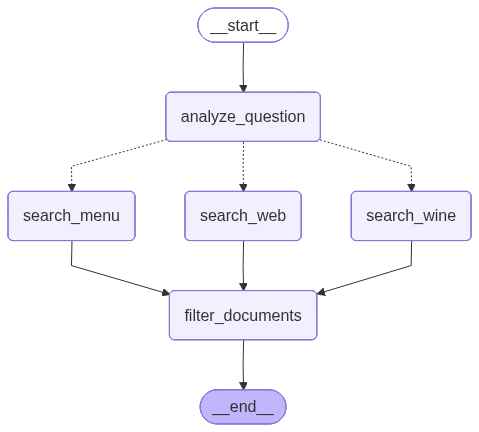

In [48]:
### 메뉴 정보에 대한 내용과, 웹 검색 내용을 구분하여 각각 정보를 추출하고 이를 기반으로 최종 답변을 생성

# 상태를 수정 (Reducer 적용)
from typing import List, TypedDict, Annotated, Sequence
from langchain_core.documents import Document
from operator import add

# 기존 SearchState 상속해서 새로 정의
class ToolSearchState(SearchState): 
    # question: str                                              
    # documents: Annotated[List[Document], add]     # 컨텍스트 문서를 추가 
    # filtered_documents: List[Document]            # 컨텍스트 문서 중에서 질문에 대답할 수 있는 문서를 필터링
    datasources: List[str]                          # 참조할 데이터 소스 

# 질문 라우팅 노드 
def analyze_question_tool_search(state: ToolSearchState):

    print("---ROUTE QUESTION---")
    question = state["question"]
    
    result = question_tool_router.invoke({"question": question})
    datasources = [tool.tool for tool in result.tools]

    return {"datasources": datasources}


def route_datasources_tool_search(state: ToolSearchState) -> Sequence[str]:

    if set(state['datasources']) == {'search_menu'}:
        return ['search_menu']

    elif set(state['datasources']) == {'search_wine'}:
        return ['search_wine']

    elif set(state['datasources']) == {'search_web'}:
        return ['search_web']

    elif set(state['datasources']) == {'search_menu', 'search_wine'}:
        return ['search_menu', 'search_wine']
    
    elif set(state['datasources']) == {'search_menu', 'search_web'}:
        return ['search_menu', 'search_web']

    elif set(state['datasources']) == {'search_wine', 'search_web'}:
        return ['search_wine', 'search_web']

    return ['search_web', 'search_menu', 'search_wine']



# 그래프 생성을 위한 StateGraph 객체를 정의
search_builder = StateGraph(ToolSearchState)

# 각 노드를 초기화
search_builder.add_node("analyze_question", analyze_question_tool_search)       # 질문 분석 노드
search_builder.add_node("search_menu", search_menu_subgraph)                    # 메뉴 검색 노드
search_builder.add_node("search_web", search_web_subgraph)                      # 웹 검색 노드
search_builder.add_node("search_wine", search_wine_subgraph)                    # 와인 검색 노드
search_builder.add_node("filter_documents", filter_documents_subgraph)          # 문서 평가 노드

# 그래프 로직 정의
search_builder.add_edge(START, "analyze_question")  # 시작점에서 질문 분석 노드로
search_builder.add_conditional_edges(
    "analyze_question",
    route_datasources_tool_search,
    ["search_menu", "search_web", "search_wine"]
)
search_builder.add_edge("search_menu", "filter_documents")  # 메뉴 검색 결과를 문서 평가 노드로
search_builder.add_edge("search_web", "filter_documents")   # 웹 검색 결과를 문서 평가 노드로
search_builder.add_edge("search_wine", "filter_documents")  # 와인 검색 결과를 문서 평가 노드로
search_builder.add_edge("filter_documents", END)  # 문서 평가 노드에서 종료점으로

# 그래프 컴파일
tool_search_graph = search_builder.compile()

# 그래프 시각화 
display(Image(tool_search_graph.get_graph().draw_mermaid_png()))

In [49]:
result = tool_search_graph.invoke({"question": "스테이크 매뉴가 있으면 추천해주세요."})
result

---ROUTE QUESTION---
--- 문서 관련성 평가 ---
---문서 관련성: 있음---
---문서 관련성: 있음---


{'question': '스테이크 매뉴가 있으면 추천해주세요.',
 'documents': [Document(metadata={'menu_name': '시그니처 스테이크', 'menu_number': 1, 'source': './data/restaurant_menu.txt'}, page_content='1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.'),
  Document(metadata={'menu_name': '시그니처 스테이크', 'menu_number': 1, 'source': './data/restaurant_menu.txt'}, page_content='1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.')],
 'filtered_documents': [Document(metadata={'menu_name': '시그니처 스테이크', 'menu_number': 1, 'source': './data/restaurant_menu.txt'}, page_content='1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건

In [50]:
result = tool_search_graph.invoke({"question": "스테이크 매뉴가 있으면 추천해주세요. 그리고 어울리는 와인도 소개해주세요."})
result

---ROUTE QUESTION---
--- 문서 관련성 평가 ---
---문서 관련성: 있음---
---문서 관련성: 있음---
---문서 관련성: 없음---
---문서 관련성: 없음---


{'question': '스테이크 매뉴가 있으면 추천해주세요. 그리고 어울리는 와인도 소개해주세요.',
 'documents': [Document(metadata={'menu_name': '시그니처 스테이크', 'menu_number': 1, 'source': './data/restaurant_menu.txt'}, page_content='1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.'),
  Document(metadata={'menu_name': '시그니처 스테이크', 'menu_number': 1, 'source': './data/restaurant_menu.txt'}, page_content='1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.'),
  Document(metadata={'menu_name': '풀리니 몽라쉐 1er Cru 2018', 'menu_number': 7, 'source': './data/restaurant_wine.txt'}, page_content='7. 풀리니 몽라쉐 1er Cru 2018\n   • 가격: ₩320,000\n   • 주요 품종: 샤르도네\n   • 설명: 부르고뉴 최고의 화이트 와인 중 하나로 꼽힙니다. 레

In [51]:
result = tool_search_graph.invoke({"question": "파스타 매뉴가 있으면 추천해주세요. 그리고, 파스타의 유래에 대해 알려주세요."})
result

---ROUTE QUESTION---
--- 문서 관련성 평가 ---
---문서 관련성: 있음---
---문서 관련성: 있음---
---문서 관련성: 없음---
---문서 관련성: 없음---


{'question': '파스타 매뉴가 있으면 추천해주세요. 그리고, 파스타의 유래에 대해 알려주세요.',
 'documents': [Document(metadata={'menu_name': '해산물 파스타', 'menu_number': 6, 'source': './data/restaurant_menu.txt'}, page_content='6. 해산물 파스타\n   • 가격: ₩24,000\n   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스\n   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.'),
  Document(metadata={'menu_name': '해산물 파스타', 'menu_number': 6, 'source': './data/restaurant_menu.txt'}, page_content='6. 해산물 파스타\n   • 가격: ₩24,000\n   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스\n   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.'),
  Document(metadata={'source': 'web search', 'url': 'https://www.youtube.com/watch?v=JOsw6VBXLXk'}, page_content='<Document href="https://www.youtube.com/watch?v=JOsw6VBXLXk"/>\n꽤 돼 가지고 파스타 하나씩 나눠 먹으면 양이 진짜 많을 것 같아요 [음악] [음악] 약간 위에 양파 볶은 것도 있고 마늘도 이렇게 있어가지고 양파맛도 여기 지금 양파맛집이야 오 이게이 소스가 데미소스예

`(3) 기존 Self-RAG 그래프와 결합`

- 다중 스키마 사용 (search_graph의 상위 그래프를 정의하고 OverallState 상태를 별도로 정의)

In [52]:
from typing import List, TypedDict
from langchain_core.documents import Document

# 상태를 초기화 (SelfRagState 클래스 상속)
class SelfRagOverallState(SelfRagState):
    # question: str                       # 사용자의 질문
    # generation: str                     # LLM 생성 답변
    # documents: List[Document]           # 컨텍스트 문서 (검색된 문서)
    # num_generations: int                # 질문 or 답변 생성 횟수 (무한 루프 방지에 활용)
    filtered_documents: List[Document]    # 컨텍스트 문서 중에서 질문에 대답할 수 있는 문서를 필터링

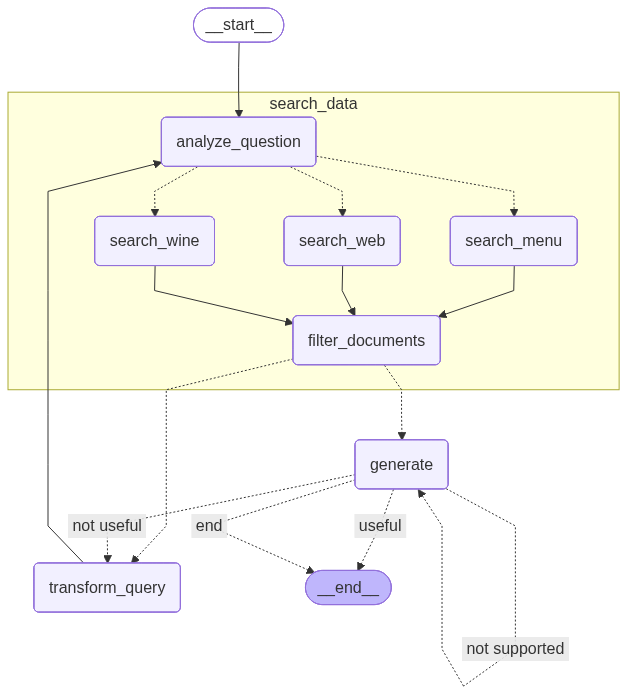

In [53]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 워크플로우 그래프 초기화
rag_builder = StateGraph(SelfRagOverallState)

# 검색 단계 서브 그래프 컴파일
tool_search_graph = search_builder.compile()

# 노드 정의
rag_builder.add_node("search_data", tool_search_graph)         # 문서 검색
rag_builder.add_node("generate", generate_self)                # 답변 생성
rag_builder.add_node("transform_query", transform_query_self)  # 질문 개선

# 그래프 구축
rag_builder.add_edge(START, "search_data")

# 조건부 엣지 추가: 문서 평가 후 결정
rag_builder.add_conditional_edges(
    "search_data",
    decide_to_generate_self,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
rag_builder.add_edge("transform_query", "search_data")

# 조건부 엣지 추가: 답변 생성 후 평가
rag_builder.add_conditional_edges(
    "generate",
    grade_generation_self,
    {
        "not supported": "generate",          # 환각이 발생한 경우 -> 답변을 다시 생성 
        "not useful": "transform_query",      # 질문과 답변의 관련성이 부족한 경우 -> 쿼리 개선해서 다시 검색 
        "useful": END, 
        "end": END,
    },
)

# 그래프 컴파일
adaptive_self_rag = rag_builder.compile()

# 그래프 시각화
display(Image(adaptive_self_rag.get_graph(xray=True).draw_mermaid_png()))

In [54]:
inputs = {"question": "이 식당의 대표 메뉴는 무엇인가요? 주재료는 무엇인가요?"}
final_output = adaptive_self_rag.invoke(inputs)

---ROUTE QUESTION---
--- 문서 관련성 평가 ---
---문서 관련성: 있음---
---문서 관련성: 있음---
--- 평가된 문서 분석 ---
--- 결정: 답변 생성 (-> generate)---
--- 답변 생성 ---
--- 환각 여부 확인 ---
--- 결정: 환각이 없음 (답변이 컨텍스트에 근거함) ---
---질문-답변 관련성 확인---
--- 결정: 생성된 답변이 질문을 잘 다룸 (-> END) ---


In [55]:
# 최종 답변 
print(final_output["generation"])

이 식당의 대표 메뉴는 "시그니처 스테이크"입니다. 주재료는 "최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스"입니다.


In [56]:
inputs = {"question": "스테이크 메뉴가 있나요? 어울리는 와인이 있을까요?"}
for output in adaptive_self_rag.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

---ROUTE QUESTION---
--- 문서 관련성 평가 ---
---문서 관련성: 있음---
---문서 관련성: 있음---
---문서 관련성: 없음---
---문서 관련성: 없음---
--- 평가된 문서 분석 ---
--- 결정: 답변 생성 (-> generate)---
"Node 'search_data':"
("Value: {'question': '스테이크 메뉴가 있나요? 어울리는 와인이 있을까요?', 'documents': "
 "[Document(metadata={'menu_name': '시그니처 스테이크', 'menu_number': 1, 'source': "
 "'./data/restaurant_menu.txt'}, page_content='1. 시그니처 스테이크\\n   • 가격: "
 '₩35,000\\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\\n   • 설명: 셰프의 특제 시그니처 '
 '메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 '
 "아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.'), "
 "Document(metadata={'menu_name': '시그니처 스테이크', 'menu_number': 1, 'source': "
 "'./data/restaurant_menu.txt'}, page_content='1. 시그니처 스테이크\\n   • 가격: "
 '₩35,000\\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\\n   • 설명: 셰프의 특제 시그니처 '
 '메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 '
 "아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.'), "
 "Document(m

In [57]:
# 최종 답변
print(value["generation"])

네, 스테이크 메뉴로 "시그니처 스테이크"가 있습니다. 가격은 ₩35,000이며, 최상급 한우 등심을 사용한 미디엄 레어 스테이크입니다. 어울리는 와인으로는 "풀리니 몽라쉐 1er Cru 2018"이 추천됩니다. 이 와인은 해산물, 닭고기, 크림 소스 파스타와 좋은 페어링을 이룹니다.


## 5. Corrective RAG (CRAG) 구현
- CRAG (Corrective Retrieval-Augmented Generation) 
- 논문: https://arxiv.org/pdf/2401.15884

- 주요 과정: 검색 -> 평가 -> 지식 정제 또는 웹 검색 -> 답변 생성

   1. 문서 관련성 평가 (`grade_documents`):
      - 각 문서의 관련성을 평가
      - 기준을 통과하는 문서만을 유지

   1. 지식 정제 (`refine_knowledge`):
      - 문서를 "지식 조각"으로 분할하고 각각의 관련성을 평가
      - 관련성 높은(0.5 초과) 지식 조각만 유지

   1. 웹 검색 (`web_search`):
      - 문서가 충분한 정보를 담지 못한 경우 외부 지식을 활용
      - 웹 검색 결과를 기존 문서에 추가 

   1. 답변 생성 (`generate_answer`):
      - 정제된 지식 조각을 사용하여 답변을 생성
      - 관련 정보가 없을 경우 적절한 메시지를 반환



### 5-1. LLM 체인 추가

`(1) Knowledge Refiner`

In [58]:
# 지식 정제를 위한 클래스
class RefinedKnowledge(BaseModel):
    """
    Represents a refined piece of knowledge extracted from a document.
    """

    knowledge_strip: str = Field(description="A refined piece of knowledge extracted from a document")
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM 모델 초기화 및 구조화된 출력 설정
llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_refiner = llm.with_structured_output(RefinedKnowledge)

# 지식 정제를 위한 프롬프트
system_prompt = """
    You are an expert in knowledge refinement. Your task is to extract key information from the given document related to the provided question and evaluate its relevance.

    [Instructions]
    1. 질문과 문서를 주의 깊게 읽습니다.
    2. 질문에 답하는 데 관련된 문서 내의 주요 정보를 식별합니다.
    3. 각 주요 정보에 대해:
        a. 간결하게 추출하고 요약합니다 (정보당 1-2문장을 목표로 합니다).
        b. 질문에 대한 관련성을 'yes' (관련 있음) 또는 'no' (관련 없음)로 평가합니다.
    4. 각 정보를 다음 형식으로 새 줄에 제시합니다:
        [추출된 정보] (yes/no)

    [Example Output]
    AI 시스템은 학습 데이터에 존재하는 편향을 나타낼 수 있습니다. (yes)
    의사 결정에 AI를 사용하는 것은 프라이버시 문제를 제기합니다. (yes)
    기계 학습 모델은 상당한 컴퓨팅 자원을 필요로 합니다. (no)

    [Note]
    Focus on extracting factual and objective information. Avoid personal opinions or speculations. Aim to provide 3-5 key pieces of information, but you may include more if the document is particularly rich in relevant content.
    """

# 지식정제를 위한 프롬프트 템플릿 생성
refine_prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", "[Document]\n{document}\n\n[User question]\n{question}"),
])

# Knowledge Refiner 파이프라인 구성
knowledge_refiner = refine_prompt | structured_llm_refiner

# 지식 정제 실행
retrieved_docs = search_menu.invoke(question)
print(f"검색된 문서 수: {len(retrieved_docs)}")

for test_chunk in retrieved_docs:
    print("문서:", test_chunk.page_content)

    refined_knowledge = knowledge_refiner.invoke({"question": question, "document": test_chunk})
    print(f"정제된 지식: {refined_knowledge.knowledge_strip}")
    print(f"정제된 지식 평가: {refined_knowledge.binary_score}")
    print("=====================================")


검색된 문서 수: 2
문서: 1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
정제된 지식: 시그니처 스테이크는 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다.
정제된 지식 평가: yes
문서: 1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
정제된 지식: 시그니처 스테이크는 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다.
정제된 지식 평가: yes


`(2) Retrieval Grader 수정`

In [59]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# 문서 관련성 평가 결과를 위한 데이터 모델 정의
class MultiGradeDocuments(BaseModel):
    """Three-class score for relevance check on retrieved documents."""

    relevance_score: Literal["correct", "incorrect", "ambiguous"] = Field(
        description="Document relevance to the question: 'correct', 'incorrect', or 'ambiguous'"
    )

# LLM 모델 초기화 및 구조화된 출력 설정
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(MultiGradeDocuments)

# 문서 관련성 평가를 위한 시스템 프롬프트 정의
system_prompt = """
You are an expert evaluator tasked with assessing the relevance of retrieved documents to a user's question. Your role is crucial in enhancing the quality of information retrieval systems.

[평가 기준]
1. 키워드 관련성: 문서가 질문의 주요 단어나 유사어를 포함하는지 확인
2. 의미적 관련성: 문서의 전반적인 주제가 질문의 의도와 일치하는지 평가
3. 부분 관련성: 질문의 일부를 다루거나 맥락 정보를 제공하는 문서도 고려
4. 답변 가능성: 직접적인 답이 아니더라도 답변 형성에 도움될 정보 포함 여부 평가

[점수 체계]
- 'Correct': 문서가 명확히 관련 있고, 질문에 답하는 데 필요한 정보를 포함함.
- 'Incorrect': 문서가 명확히 무관하거나, 질문에 도움이 되지 않는 정보를 포함함.
- 'Ambiguous': 문서의 관련성이 불분명하거나, 일부 관련 정보는 있지만 유용성이 확실하지 않음, 혹은 질문과 약간만 관련 있음.

[주의사항]
- 단순 단어 매칭이 아닌 질문의 전체 맥락을 고려하세요
- 완벽한 답변이 아니어도 유용한 정보가 있다면 관련 있다고 판단하세요

Your evaluation plays a critical role in improving the overall performance of the information retrieval system. Strive for balanced and thoughtful assessments.
"""

# 채점 프롬프트 템플릿 생성
grade_prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", "Document: \n\n {document} \n\n Question: {question}"),
])

# Retrieval Grader 파이프라인 구성
retrieval_grader_multi = grade_prompt | structured_llm_grader
    
# 관련성 평가 실행
question = "비건 메뉴가 있나요?"
retrieved_docs = search_menu.invoke(question)
print(f"검색된 문서 수: {len(retrieved_docs)}")

for test_chunk in retrieved_docs:
    print("문서:", test_chunk.page_content)

    relevance = retrieval_grader_multi.invoke({"question": question, "document": test_chunk.page_content})
    print(f"문서 관련성: {relevance.relevance_score}")
    print("=====================================")

검색된 문서 수: 2
문서: 7. 랍스터 비스크
   • 가격: ₩28,000
   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카
   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.
문서 관련성: incorrect
문서: 7. 랍스터 비스크
   • 가격: ₩28,000
   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카
   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.
문서 관련성: incorrect


### 5-2. LangGraph로 그래프 구현

`(1) 그래프 State 생성`

In [60]:
# LangGraph MessagesState라는 미리 만들어진 상태를 사용
from langgraph.graph import MessagesState
from typing import List, Tuple
from langchain_core.documents import Document

class CorrectiveRagState(MessagesState):
    """
    메시지 기반 그래프의 상태를 나타내는 클래스
    
    Attributes:
        messages: 대화 히스토리 (기본 제공, 설정 불필요)
        question: 사용자의 질문
        generation: AI 모델의 답변
        retrieved_documents: 검색된 문서 리스트 (문서, 점수)
        knowledge_strips: 지식 보강한 결과 리스트 (문서, 점수)
        num_generations: 생성 횟수 (무한 루프 방지에 활용)
    """
    question: str
    generation: str
    retrieved_documents: List[Tuple[Document, str]] 
    knowledge_strips: List[Tuple[Document, str]] 
    num_generations: int 

`(2) Node 구성`

In [61]:
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, AIMessage

def retrieve_crag(state: CorrectiveRagState):
    """문서를 검색하는 함수"""
    print("--- 문서 검색 ---")
    question = state["question"]
    
    # 문서 검색 로직
    retrieved_documents = search_menu.invoke(question)
    retrieved_documents = [(doc, "ambiguous") for doc in retrieved_documents]

    return {"retrieved_documents": retrieved_documents}

def grade_documents_crag(state: CorrectiveRagState):
    """검색된 문서의 관련성을 평가하는 함수"""
    print("--- 문서 관련성 평가 ---")
    question = state["question"]
    retrieved_documents = state.get("retrieved_documents", [])
    knowledge_strips = state.get("knowledge_strips", [])
    
    scored_docs = []
    for doc, _ in retrieved_documents:
        score = retrieval_grader_multi.invoke({"question": question, "document": doc.page_content})
        grade = score.relevance_score.lower()
        if grade == "correct":
            print("---문서 관련성: 있음---")
            scored_docs.append((doc, "correct"))
            knowledge_strips.append((doc, "correct"))
        elif grade == "incorrect":
            print("---문서 관련성: 없음---")
            scored_docs.append((doc, "incorrect"))
        else:
            print("---문서 관련성: 모호함---")
            scored_docs.append((doc, "ambiguous"))

    return {"retrieved_documents": scored_docs, "knowledge_strips": knowledge_strips}

def refine_knowledge_crag(state: CorrectiveRagState):
    """지식을 정제하는 함수"""
    print("--- 지식 정제 ---")
    question = state["question"]
    knowledge_strips = state.get("knowledge_strips", [])
    
    refined_docs = []
    for doc, score in knowledge_strips:
        if score == "incorrect":
            continue

        refined_knowledge = knowledge_refiner.invoke({"question": question, "document": doc.page_content})
        knowledge = refined_knowledge.knowledge_strip
        grade = refined_knowledge.binary_score
        if grade == "yes":
            print("---정제된 지식: 추가---")
            refined_docs.append((Document(page_content=knowledge), "correct"))
    
    return {"knowledge_strips": refined_docs}

def web_search_crag(state: CorrectiveRagState):
    """웹 검색을 수행하는 함수"""
    print("--- 웹 검색 ---")
    question = state["question"]
    
    search_results = search_web.invoke(question)

    scored_docs = []
    for result in search_results:
        score = retrieval_grader_multi.invoke({"question": question, "document": result})
        grade = score.relevance_score.lower()
        if grade == "correct":
            print("---웹 검색 문서 관련성: 있음---")
            scored_docs.append((result, "correct"))
        else:
            print("---웹 검색 문서 관련성: 없음---")

    return {"knowledge_strips": scored_docs}

def generate_crag(state: CorrectiveRagState):
    """답변을 생성하는 함수"""
    print("--- 답변 생성 ---")
    question = state["question"]
    knowledge_strips = state.get("knowledge_strips", [])
    
    doc_texts = [doc for doc, _ in knowledge_strips]
    generation = generator_rag_answer(question, docs=doc_texts)

    return {
        "generation": generation, 
        "messages": [AIMessage(content=generation)]            # 기존 메시지에 추가 
    }

def transform_query_crag(state: CorrectiveRagState):
    """질문을 개선하는 함수"""
    print("--- 질문 개선 ---")
    question = state["question"]
    num_generations = state.get("num_generations", 0)
    num_generations += 1
    
    rewritten_question = rewrite_question(question)
    
    return {
        "question": rewritten_question,
        "num_generations": num_generations,
        "messages": [HumanMessage(content=rewritten_question)]  # 기존 메시지에 추가 
    }

`(3) Edge 구성`

In [62]:
def decide_to_generate_crag(state: CorrectiveRagState):
    """답변 생성 여부를 결정하는 함수"""
    print("--- 평가된 문서 분석 ---")
    knowledge_strips = state.get("knowledge_strips", None)
    
    if not knowledge_strips:
        print("--- 결정: 모든 문서가 질문과 관련이 없음, 질문 개선 필요 (-> transform_query)---")
        return "transform_query"
    else:
        print("--- 결정: 답변 생성 (-> generate)---")
        return "generate"

`(4) 그래프 연결`

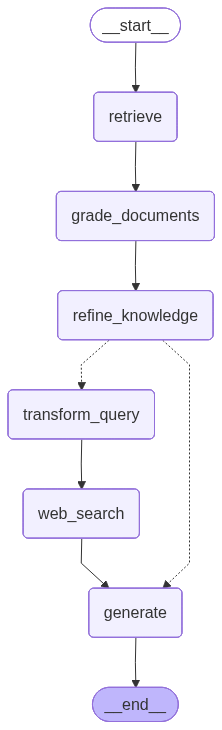

In [63]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# 워크플로우 그래프 초기화
builder = StateGraph(CorrectiveRagState)

# 노드 정의
builder.add_node("retrieve", retrieve_crag)                  # 문서 검색 
builder.add_node("grade_documents", grade_documents_crag)    # 문서 평가
builder.add_node("refine_knowledge", refine_knowledge_crag)  # 지식 정제
builder.add_node("web_search", web_search_crag)              # 웹 검색
builder.add_node("generate", generate_crag)                  # 답변 생성
builder.add_node("transform_query", transform_query_crag)    # 질문 개선


# 경로 정의
builder.add_edge(START, "retrieve")
builder.add_edge("retrieve", "grade_documents")
builder.add_edge("grade_documents", "refine_knowledge")

# 조건부 엣지 추가: 문서 평가 후 결정
builder.add_conditional_edges(
    "refine_knowledge",
    decide_to_generate_crag,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)

# 추가 경로 
builder.add_edge("transform_query", "web_search")
builder.add_edge("web_search", "generate")
builder.add_edge("generate", END)


# 그래프 컴파일
corrective_rag = builder.compile()

# 그래프 시각화
display(Image(corrective_rag.get_graph().draw_mermaid_png()))

`(5) 그래프 실행`

In [64]:
inputs = {"question": "스테이크 메뉴의 가격은 얼마인가요?"}

for output in corrective_rag.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

--- 문서 검색 ---
"Node 'retrieve':"
("Value: {'retrieved_documents': [(Document(metadata={'menu_name': '시그니처 "
 "스테이크', 'menu_number': 1, 'source': './data/restaurant_menu.txt'}, "
 "page_content='1. 시그니처 스테이크\\n   • 가격: ₩35,000\\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 "
 '감자, 그릴드 아스파라거스\\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 '
 '레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 '
 "풍부한 맛을 더합니다.'), 'ambiguous'), (Document(metadata={'menu_name': '시그니처 스테이크', "
 "'menu_number': 1, 'source': './data/restaurant_menu.txt'}, page_content='1. "
 '시그니처 스테이크\\n   • 가격: ₩35,000\\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 '
 '아스파라거스\\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 '
 '조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 '
 "맛을 더합니다.'), 'ambiguous')]}")

----------------------------------------------------------

--- 문서 관련성 평가 ---
---문서 관련성: 있음---
---문서 관련성: 있음---
"Node 'grade_documents':"
("Value: {'retrieved_

In [65]:
# 최종 답변
print(value["generation"])

스테이크 메뉴의 가격은 ₩35,000입니다.


In [66]:
inputs = {"question": "스테이크에 어울리는 와인을 추천해주세요."}

for output in corrective_rag.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

--- 문서 검색 ---
"Node 'retrieve':"
("Value: {'retrieved_documents': [(Document(metadata={'menu_name': '시그니처 "
 "스테이크', 'menu_number': 1, 'source': './data/restaurant_menu.txt'}, "
 "page_content='1. 시그니처 스테이크\\n   • 가격: ₩35,000\\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 "
 '감자, 그릴드 아스파라거스\\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 '
 '레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 '
 "풍부한 맛을 더합니다.'), 'ambiguous'), (Document(metadata={'menu_name': '시그니처 스테이크', "
 "'menu_number': 1, 'source': './data/restaurant_menu.txt'}, page_content='1. "
 '시그니처 스테이크\\n   • 가격: ₩35,000\\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 '
 '아스파라거스\\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 '
 '조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 '
 "맛을 더합니다.'), 'ambiguous')]}")

----------------------------------------------------------

--- 문서 관련성 평가 ---
---문서 관련성: 모호함---
---문서 관련성: 모호함---
"Node 'grade_documents':"
("Value: {'retrieve

In [67]:
# 최종 답변
print(value["generation"])

스테이크와 잘 어울리는 와인 종류는 다음과 같습니다:

1. 카베르네 소비뇽 (Cabernet Sauvignon) – 강한 탄닌과 풍부한 바디감이 특징입니다.
2. 말벡 (Malbec) – 풍부한 과일 향과 부드러운 탄닌을 가지고 있습니다.
3. 시라/쉬라즈 (Syrah/Shiraz) – 과일향과 스파이시한 풍미가 매력적입니다.
4. 메를로 (Merlot) – 부드럽고 균형 잡힌 와인으로, 고기의 풍미를 자연스럽게 살려줍니다.
5. 진판델 (Zinfandel) – 달콤한 향과 강한 바디감을 가지고 있습니다. 

이 와인들은 각각 특정한 스테이크와 잘 어울립니다.
